在過去曾經觀察到不同機構對學生人數多寡影響排名的趨勢不同的現象，因此本專案要將近兩年THE和QS兩個排名機構的公布資料加以比較，判斷該現象是否仍然存在，並找出可能影響排名的因素。

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# read data
qs_2023 = pd.read_csv('../QS/qs_2023_refine.csv')
the_2023 = pd.read_csv('../THE/the_2023_refine.csv')

觀察離群值

In [25]:
rbind_students = np.r_[qs_2023['Total students'], the_2023['Total Students']]
mean_rbind_students = rbind_students.mean()
std_rbind_students = rbind_students.std()

In [29]:
outlier_qs = qs_2023[(qs_2023['Total students'] > mean_rbind_students + 3*std_rbind_students) | \
        (qs_2023['Total students'] < mean_rbind_students - 3*std_rbind_students)]

(array([2., 0., 0., 1., 0., 2., 3., 0., 4., 3.]),
 array([  67. ,  190.3,  313.6,  436.9,  560.2,  683.5,  806.8,  930.1,
        1053.4, 1176.7, 1300. ]),
 <BarContainer object of 10 artists>)

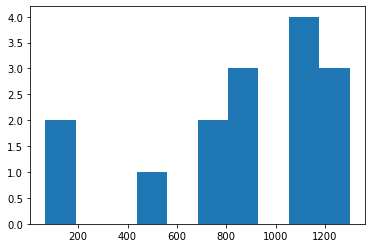

In [30]:
plt.hist(outlier_qs['rank'])

In [32]:
outlier_the = the_2023[(the_2023['Total Students'] > mean_rbind_students + 2*std_rbind_students) | \
        (the_2023['Total Students'] < mean_rbind_students - 2*std_rbind_students)]

(array([1., 2., 0., 2., 0., 5., 8., 0., 9., 5.]),
 array([  18. ,  151.2,  284.4,  417.6,  550.8,  684. ,  817.2,  950.4,
        1083.6, 1216.8, 1350. ]),
 <BarContainer object of 10 artists>)

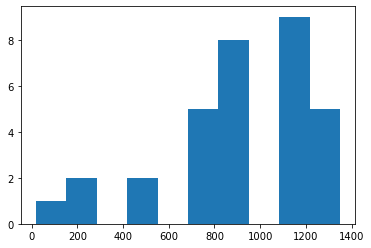

In [33]:
plt.hist(outlier_the['rank'])

outlier較常發生在名次較後面的國家

#### QS
- 比較QS學生人數, 師生比, 國際學生人數是否影響 rank

定義變數

In [34]:
X1 = qs_2023['Total students']
X2 = qs_2023['International students']
X3 = qs_2023['Total students'] / qs_2023['Total faculty staff']
y = qs_2023['rank']

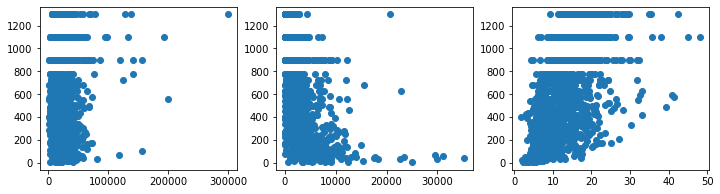

In [39]:
fig = plt.figure(figsize=(12, 3)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(X2, y, 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(X3, y, 'o')
plt.show()

In [40]:
X = np.c_[X1, X2, X3]
lm = LinearRegression()
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.43
第 [] 個變數不顯著


試著調整離群值較多的$x_2, x_3$

In [41]:
X = np.c_[X1, X2**0.5, np.log(X3)]
y = qs_2023['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.54
第 [] 個變數不顯著


In [42]:
reg.coef_.tolist()

[0.0011908130454726354, -7.608094485776371, 397.0182705989192]

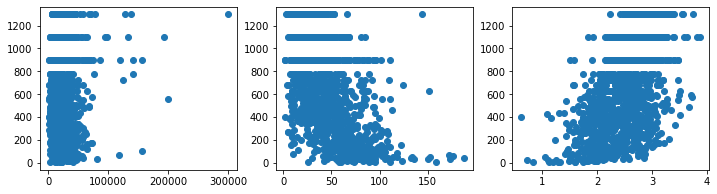

In [45]:
fig = plt.figure(figsize=(12, 3)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(X2**0.5, y, 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(np.log(X3), y, 'o')
plt.show()

最終模型寫為  
    $\hat{y} = 0.002 x_1 -7.61 \sqrt{x_2} + 397.02 \log(x_3)$

#### THE
比較THE學生人數, 師生比, 國際學生人數是否影響 rank

In [46]:
X1 = the_2023['Total Students']
X2 = the_2023['Total Students'] * the_2023['pc of int\'l students']
X3 = the_2023['student staff ratio']
y = the_2023['rank']

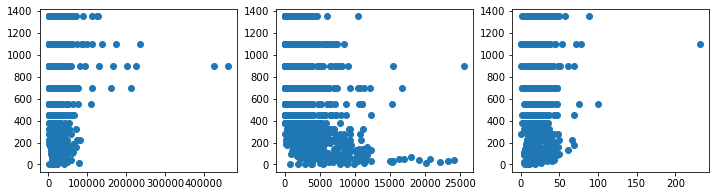

In [48]:
fig = plt.figure(figsize=(12, 3)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(X2, y, 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(X3, y, 'o')
plt.show()

In [49]:
X = np.c_[X1, X2**0.5, np.log(X3)]

reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.3
第 [] 個變數不顯著


In [50]:
reg.coef_

array([ 2.46336985e-03, -8.44098754e+00,  3.63892414e+01])

由以上結果可知THE的資料本身就比較分散，且排名大於200以上的資料就由區間代替。
因此較無法看出資料和排名的關係，即使做了特徵轉換，關係仍不明顯。

由上述的分析結果可以知道
- QS的資料較能解釋排名的變異  

近年來, 兩個機構間學生人數對排名的影響的差異以減少, 不論是THE還是QS的資料皆顯示學生人數越多平均下來排名也會越後,因此為了不同排名機構而報不同學生人數的現象也會因此減少

#### 合併QS, THE  

In [51]:
merge_table = pd.merge(the_2023, qs_2023, how = 'outer', on = 'University')

In [54]:
print('QS的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_x'].isna()]['University']), '所')

QS的學校,但和THE對不起來共有 623 所


In [55]:
print('THE的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_y'].isna()]['University']), '所')

THE的學校,但和THE對不起來共有 698 所


合併資料，觀察兩個排名的各資料差異大小

In [56]:
merge_inner = pd.merge(the_2023, qs_2023, how = 'inner', on = 'University')

In [62]:
merge_inner = merge_inner.rename(columns={'rank_x':'rank_the', 'rank_y':'rank_qs', \
                                          'Total Students':'students_the', 'Total students':'students_qs'})

In [97]:
diff = merge_inner['students_the']-merge_inner['students_qs']

mean_diff = diff.mean()
std_diff = diff.std()
ste_diff = std_diff/(merge_inner.shape[0]**0.5)

print('CL upper limit:', mean_diff + stats.norm.ppf(0.975)*ste_diff)
print('CL lower limit:', mean_diff - stats.norm.ppf(0.975)*ste_diff)

CL upper limit: 1517.049575393719
CL lower limit: 49.757555886670275


計算兩個排名的學生人數差異，發現差異的信賴區間不包含0，代表同間學校在兩個排名的人數資料是有差異的，而且THE比QS來的多。

In [94]:
the_ratio = merge_inner['student staff ratio']
qs_ratio = merge_inner['students_qs']/merge_inner['Total faculty staff']

diff_ratio = the_ratio-qs_ratio
mean_diff_ratio = diff_ratio.mean()
std_diff_ratio = diff_ratio.std()
ste_diff_ratio = std_diff_ratio/(merge_inner.shape[0]**0.5)

print('CL upper limit:', mean_diff_ratio + stats.norm.ppf(0.975)*ste_diff_ratio)
print('CL lower limit:', mean_diff_ratio - stats.norm.ppf(0.975)*ste_diff_ratio)

CL upper limit: 5.0127330349155805
CL lower limit: 3.894580429754896


計算兩個排名的師生比差異，發現差異的信賴區間不包含0，代表同間學校在兩個排名的師生比是有差異的，而且THE比QS來的大。

In [96]:
the_intl = merge_inner['pc of int\'l students']
qs_intl = merge_inner['International students']/merge_inner['students_qs']

diff_intl = the_intl-qs_intl
mean_diff_intl = diff_intl.mean()
std_diff_intl = diff_intl.std()
ste_diff_intl = std_diff_intl/(merge_inner.shape[0]**0.5)

print('CL upper limit:', mean_diff_intl + stats.norm.ppf(0.975)*ste_diff_intl)
print('CL lower limit:', mean_diff_intl - stats.norm.ppf(0.975)*ste_diff_intl)

CL upper limit: 0.001541406168654869
CL lower limit: -0.006743861904713992


計算兩個排名的國際學生比例差異，發現差異的信賴區間包含0，代表同間學校在兩個排名的國際學生比例是沒有差異的。